In [411]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pylab as pl

from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
import sklearn.decomposition
import sklearn.ensemble as sk
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.grid_search import GridSearchCV

import random
import sys
from scipy import stats
% matplotlib inline
%load_ext autoreload
%autoreload 2
from regression_functions import *
from reg_plots import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import the 2b fluxes

In [418]:
df_2b = pd.read_csv('data/coll_ref.csv', parse_dates = [0], index_col = 0)

In [425]:
df_2b = df_2b[0:120]

In [427]:
df_2b.tail()

,c_open,c_close
date,,
2014-07-25 19:35:20.451,56.193,43.247
2014-07-25 20:39:07.251,50.196,35.741
2014-07-25 21:42:52.251,47.867,38.648
2014-07-25 22:46:36.351,43.811,31.309
2014-07-25 23:50:22.251,39.041,30.421


In [428]:
day_hour = df_2b.reset_index().apply(lambda x: str(x.date.day) + '-'+  str(x.date.hour), axis=1)

In [429]:
df_2b['day_hour'] = list(day_hour)

In [430]:
df_2b.head()

,c_open,c_close,day_hour
date,,,
2014-07-18 17:20:25.278,54.3,42.4,18-17
2014-07-18 18:24:04.878,58.4,37.2,18-18
2014-07-18 21:34:51.978,50.3,30.1,18-21
2014-07-18 22:38:39.678,28.3,5.2,18-22
2014-07-19 02:54:06.678,29.5,16.9,19-2


#### Import the MOx fluxes

In [390]:
df_mox = pd.read_csv('data/fluxes.csv', index_col = 0, parse_dates = 0)

In [391]:
df_mox.head()

,close_conc,flux,open_conc
date,,,
2014-07-28 15:24:00,42.9,-0.336543,60.9
2014-07-28 16:28:00,42.9,-0.299150,58.9
2014-07-28 17:32:00,36.6,-0.278583,51.5
2014-07-28 18:36:00,33.8,-0.340283,52.0
2014-07-28 19:40:00,31.4,-0.231841,43.8


In [392]:
mox_day_hour = df_mox.reset_index().apply(lambda x: str(x.date.day) + '-'+  str(x.date.hour), axis=1)

In [393]:
df_mox['day_hour'] = list(mox_day_hour)

In [394]:
df_mox = df_mox.rename(columns={'close_conc':'mox_cl_conc', 'flux':'mox_flux', 'open_conc':'mox_open_conc'})

In [395]:
df_mox['hour'] = df_mox.index.hour

In [396]:
df_mox = df_mox.reset_index()

In [397]:
df = pd.merge(df_mox, df_2b, on='day_hour')

In [398]:
df = df.set_index('date')

In [399]:
df.mox_flux = -df.mox_flux
df.flux = -df.flux

In [400]:
df.head()

,mox_cl_conc,mox_flux,mox_open_conc,day_hour,hour,c_open,c_close,flux
date,,,,,,,,
2014-07-28 16:28:00,42.9,0.299150,58.9,28-16,16,86.511,64.764,0.30
2014-07-28 17:32:00,36.6,0.278583,51.5,28-17,17,76.116,65.977,0.14
2014-07-28 18:36:00,33.8,0.340283,52.0,28-18,18,64.484,48.390,0.22
2014-07-28 19:40:00,31.4,0.231841,43.8,28-19,19,67.893,46.830,0.29
2014-07-28 21:48:00,24.1,0.183229,33.9,28-21,21,32.548,24.616,0.11


In [401]:
def plot_2b_vs_mox(df, title):
    plt.figure(facecolor='w', figsize = (8,8))
    a, b, axes, label_size = plot_params()
    plt.plot(df.flux, df.mox_flux, linestyle = '', marker = 'o', alpha = .9)
    plt.xlabel('2B Ozone Flux', size = label_size)
    plt.ylabel('MOx Ozone Flux', size = label_size)
    plt.title(title, size=22)
    plt.plot([df.mox_flux.max(), df.mox_flux.min()], [df.mox_flux.max(),df.mox_flux.min()])

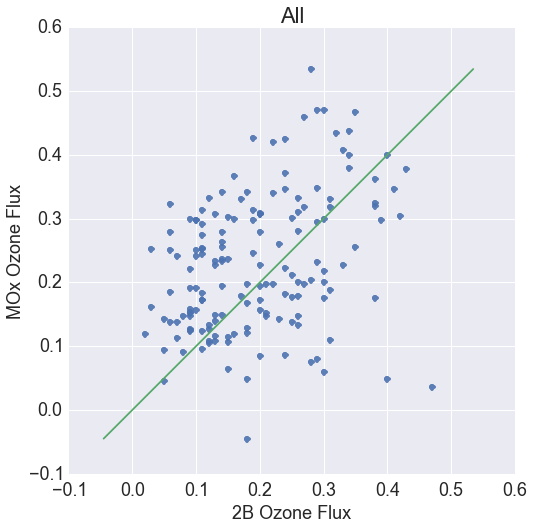

In [402]:
plot_2b_vs_mox(df, 'All')
plt.savefig("all.png")

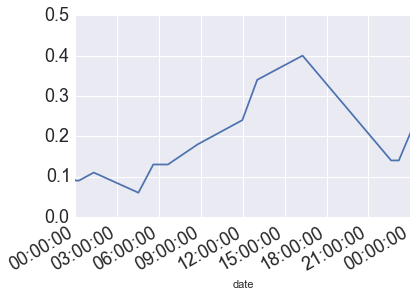

In [403]:
df.flux.plot(xlim = ['2014-08-2 00:00:00', '2014-08-3 00:00:00'])

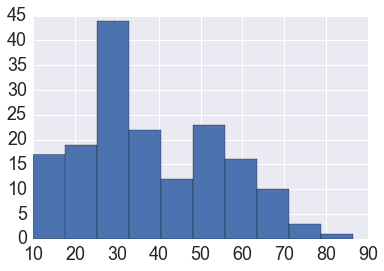

In [404]:
df.c_open.hist()

## Print Average Fluxes measured by both instruments

In [405]:
(.04)/0.19

0.21052631578947367

In [406]:
avg_flux_mox = np.mean(df.mox_flux)
avg_flux_2b = np.mean(df.flux)
print 'MOx flux:', round(avg_flux_mox, 2), "2B flux:", round(avg_flux_2b, 2)

MOx flux: 0.23 2B flux: 0.19


In [407]:
0.09/0.08

1.125

MOx flux: 0.17 2B flux: 0.08


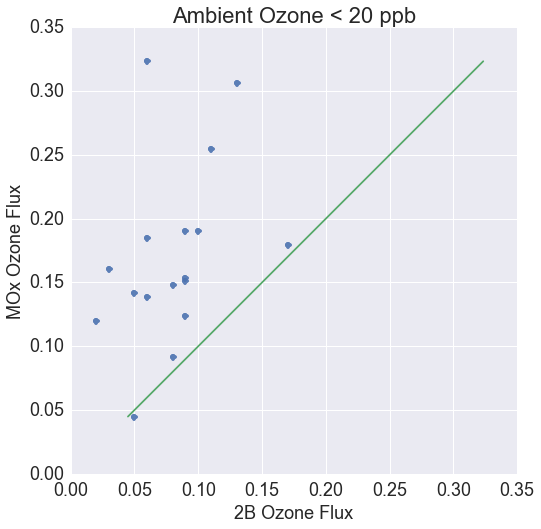

In [408]:
df_under_20 = df[df.c_open < 20]
plot_2b_vs_mox(df_under_20, 'Ambient Ozone < 20 ppb')
avg_flux_mox_under_20 = np.mean(df_under_20.mox_flux)
avg_flux_2b_under_20 = np.mean(df_under_20.flux)
print 'MOx flux:', round(avg_flux_mox_under_20, 2), "2B flux:", round(avg_flux_2b_under_20, 2)
plt.savefig("under_20.png")

MOx flux: 0.24 2B flux: 0.21


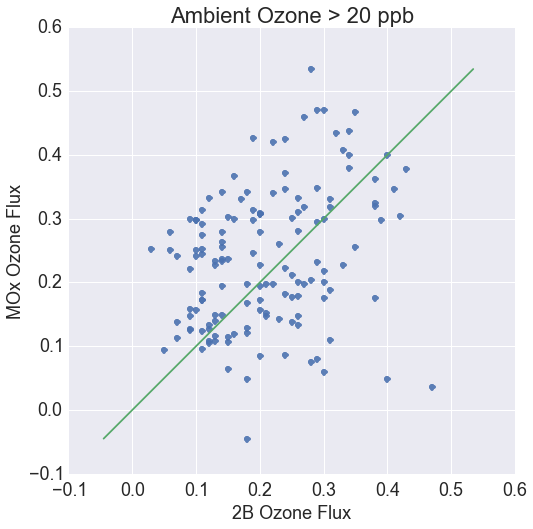

In [409]:
df_20_up = df[df.c_open > 20]
plot_2b_vs_mox(df_20_up, 'Ambient Ozone > 20 ppb')
avg_flux_mox_20_up = np.mean(df_20_up.mox_flux)
avg_flux_2b_20_up = np.mean(df_20_up.flux)
print 'MOx flux:', round(avg_flux_mox_20_up, 2), "2B flux:", round(avg_flux_2b_20_up, 2)

MOx flux: 0.18 2B flux: 0.16


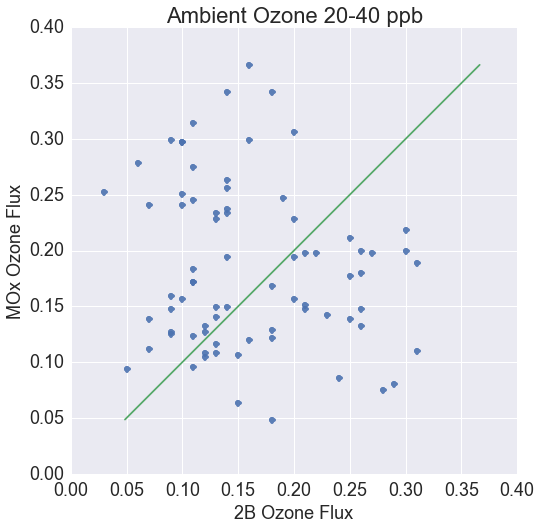

In [410]:
df_20_to_40 = df[(df.c_open < 40) & (df.c_open > 20)]
plot_2b_vs_mox(df_20_to_40, 'Ambient Ozone 20-40 ppb')
avg_flux_mox_20_to_40 = np.mean(df_20_to_40.mox_flux)
avg_flux_2b_20_to_40 = np.mean(df_20_to_40.flux)
print 'MOx flux:', round(avg_flux_mox_20_to_40, 2), "2B flux:", round(avg_flux_2b_20_to_40, 2)

MOx flux: 0.28 2B flux: 0.25


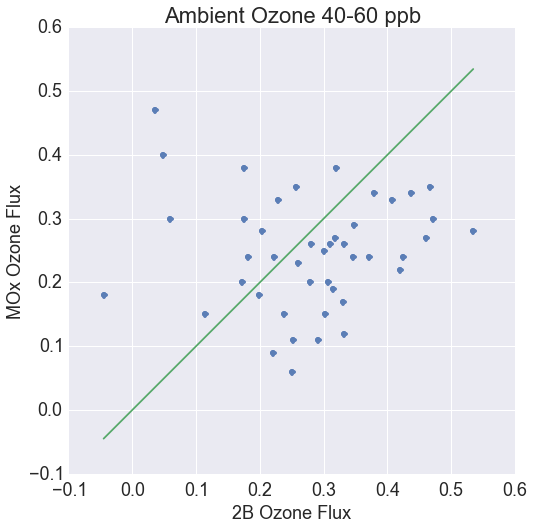

In [321]:
df_40_to_60 = df[(df.c_open < 60) & (df.c_open > 40)]
plot_2b_vs_mox(df_40_to_60, 'Ambient Ozone 40-60 ppb')
avg_flux_mox_40_to_60 = np.mean(df_40_to_60.mox_flux)
avg_flux_2b_40_to_60 = np.mean(df_40_to_60.flux)
print 'MOx flux:', round(avg_flux_mox_40_to_60, 2), "2B flux:", round(avg_flux_2b_40_to_60, 2)

MOx flux: 0.33 2B flux: 0.3


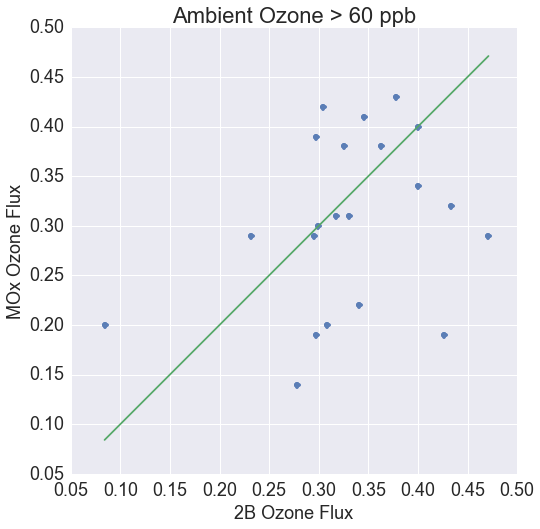

In [322]:
df_60_up = df[df.c_open > 60]
plot_2b_vs_mox(df_60_up, 'Ambient Ozone > 60 ppb')
avg_flux_mox_60_up = np.mean(df_60_up.mox_flux)
avg_flux_2b_60_up = np.mean(df_60_up.flux)
print 'MOx flux:', round(avg_flux_mox_60_up, 2), "2B flux:", round(avg_flux_2b_60_up, 2)

MOx flux: 0.25 2B flux: 0.14


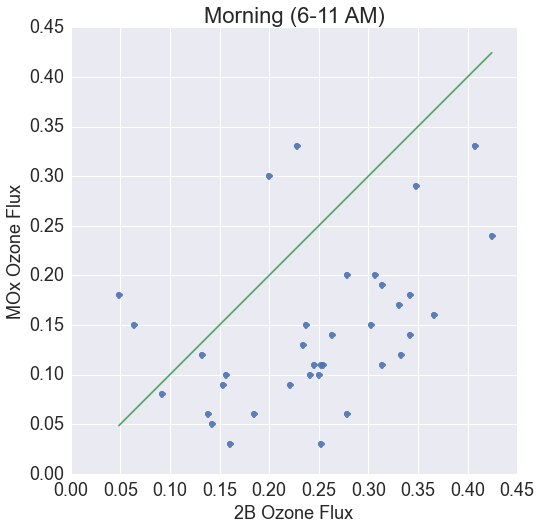

In [323]:
df_morning = df[(df.hour >= 6) & (df.hour < 12)]
plot_2b_vs_mox(df_morning, 'Morning (6-11 AM)')
avg_flux_mox_morning = np.mean(df_morning.mox_flux)
avg_flux_2b_morning = np.mean(df_morning.flux)
print 'MOx flux:', round(avg_flux_mox_morning, 2), "2B flux:", round(avg_flux_2b_morning, 2)

MOx flux: 0.32 2B flux: 0.29


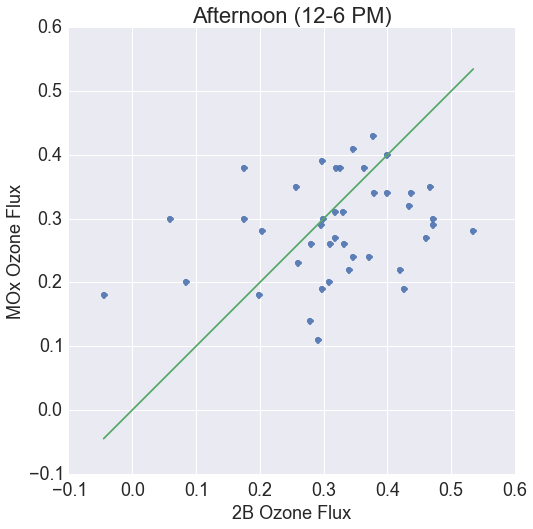

In [324]:
df_afternoon = df[(df.hour > 11) & (df.hour < 19)]
plot_2b_vs_mox(df_afternoon, 'Afternoon (12-6 PM)')
avg_flux_mox_afternoon = np.mean(df_afternoon.mox_flux)
avg_flux_2b_afternoon = np.mean(df_afternoon.flux)
print 'MOx flux:', round(avg_flux_mox_afternoon, 2), "2B flux:", round(avg_flux_2b_afternoon, 2)

MOx flux: 0.17 2B flux: 0.19


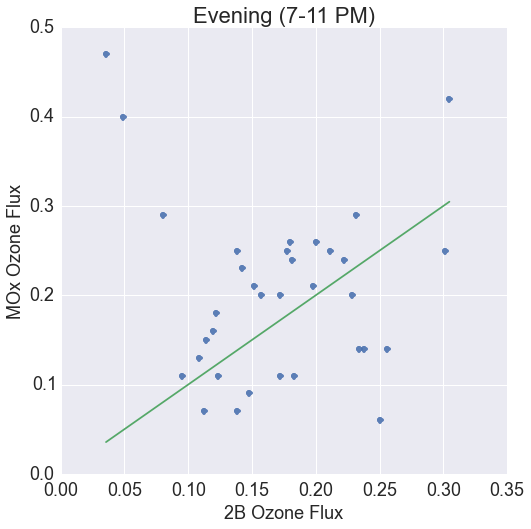

In [325]:
df_evening = df[(df.hour > 18) & (df.hour < 25)]
plot_2b_vs_mox(df_evening, 'Evening (7-11 PM)')
avg_flux_mox_evening = np.mean(df_evening.mox_flux)
avg_flux_2b_evening = np.mean(df_evening.flux)
print 'MOx flux:', round(avg_flux_mox_evening, 2), "2B flux:", round(avg_flux_2b_evening, 2)

MOx flux: 0.18 2B flux: 0.15


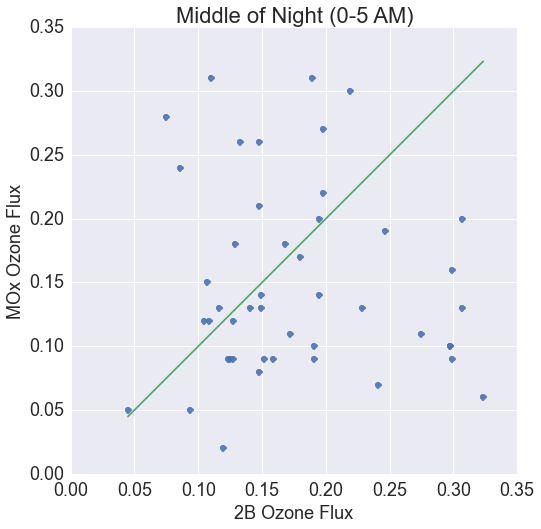

In [326]:
df_night = df[(df.hour >= 0) & (df.hour < 6)]
plot_2b_vs_mox(df_night, 'Middle of Night (0-5 AM)')
avg_flux_mox_night = np.mean(df_night.mox_flux)
avg_flux_2b_night = np.mean(df_night.flux)
print 'MOx flux:', round(avg_flux_mox_night, 2), "2B flux:", round(avg_flux_2b_night, 2)

In [327]:
def plot_mox_and_2b_vs_time(df, xlim):
    plt.figure(facecolor='w', figsize = (15,10))
    a, b, axes, label_size = plot_params()
    df.flux.plot(marker = 'o',linestyle = '--', label = '2B')
    if xlim != None:
        df.mox_flux.plot(marker = 'o',linestyle = '-', xlim = xlim, label = 'MOx')
    else:
        df.mox_flux.plot(marker = 'o',linestyle = '-', label = 'MOx')
#     axes.set_ylim([-10,90])
    plt.legend(fontsize = label_size, loc = "best")
    plt.ylabel('Ozone Flux', size = label_size)
    plt.xlabel('Date', size = label_size)

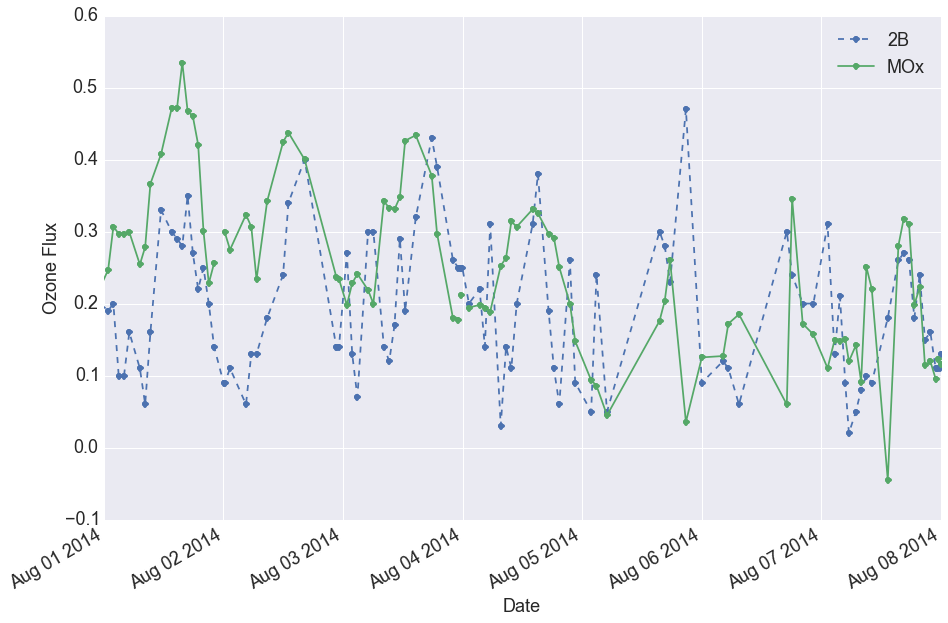

In [349]:
plot_mox_and_2b_vs_time(df, ['2014-08-1 00:00:00', '2014-08-8 00:00:00'])

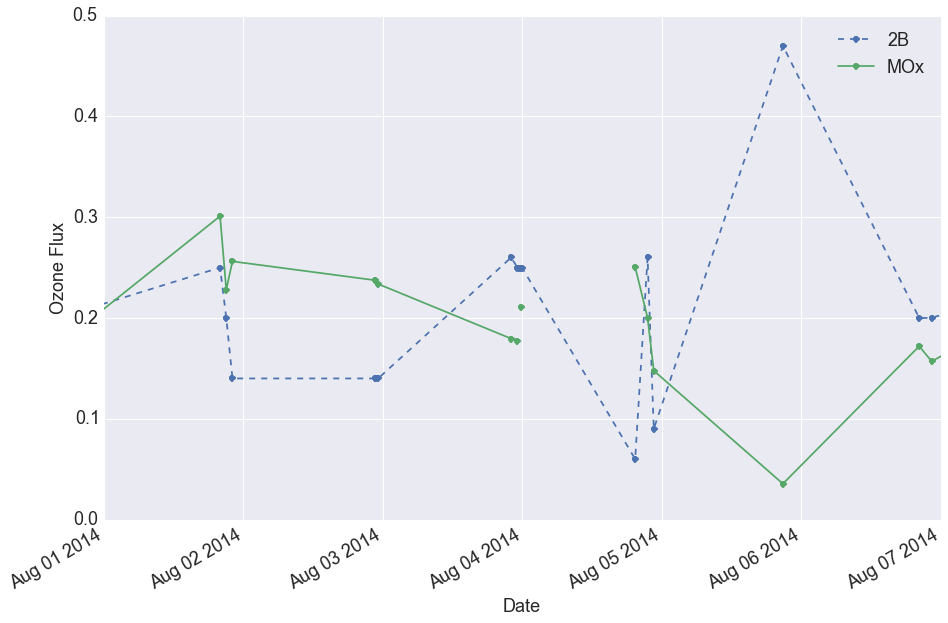

In [347]:
plot_mox_and_2b_vs_time(df_evening, ['2014-08-1 00:00:00', '2014-08-7 00:00:00'])